# README
This notebook is used for sensitivity analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import copy
import argparse
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import json
from utils.tools import dotdict
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from matplotlib import cm
from scipy import stats
import math
from scipy.optimize import curve_fit
import matplotlib
from data_provider.data_loader import fixed_files
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error

from matplotlib.font_manager import FontProperties
from scipy.stats import wilcoxon, ttest_ind, mannwhitneyu, ttest_rel

font = {'family' : 'Arial'}

matplotlib.rcParams['mathtext.fontset'] = 'custom'

matplotlib.rcParams['mathtext.rm'] = 'Arial'

matplotlib.rcParams['mathtext.it'] = 'Arial'

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42 # make the text editable for Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rc('font', **font0)

# matplotlib.rc('text', usetex=False)
def set_ax_linewidth(ax, bw=1.5):
    ax.spines['bottom'].set_linewidth(bw)
    ax.spines['left'].set_linewidth(bw)
    ax.spines['top'].set_linewidth(bw)
    ax.spines['right'].set_linewidth(bw)

def set_ax_font_size(ax, fontsize=10):
    ax.tick_params(axis='y',
                 labelsize=fontsize # y轴字体大小设置
                  ) 
    ax.tick_params(axis='x',
                 labelsize=fontsize # x轴字体大小设置
                  ) 

def set_draft(the_plt, other_ax=''):
    ax = the_plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.xlabel('')
    plt.ylabel('')
    if other_ax:
        other_ax.axes.xaxis.set_ticklabels([])
        other_ax.axes.yaxis.set_ticklabels([])
        other_ax.set_ylabel('')
        other_ax.set_xlabel('')

def set_draft_fig(fig):
    for ax in fig.axes:
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.set_ylabel('')
        ax.set_xlabel('')
    
x_y_label_size = 12 
title_size = 12 
convert_mm_to_inch = 1/25.4
dot_size = 9

metric = 'rmse' # rmse or mae

meta NOT subset; don't know how to subset; dropped


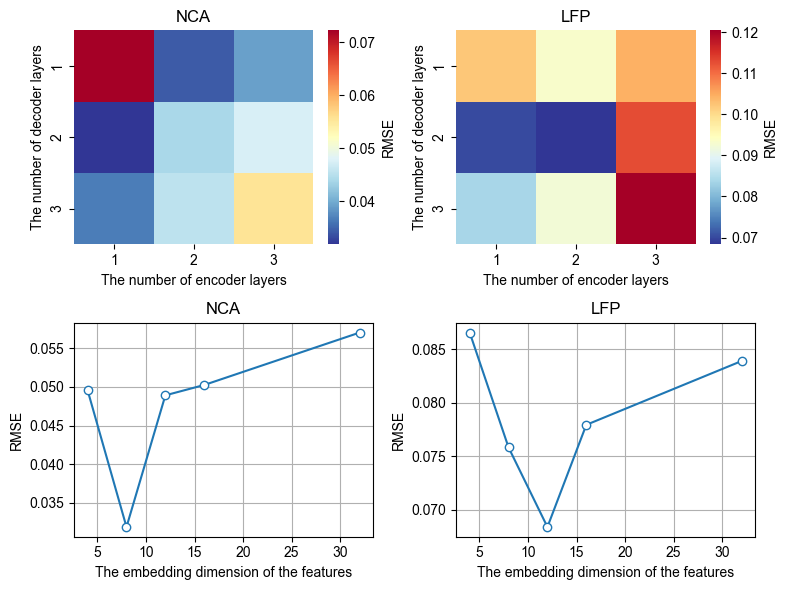

In [3]:
def return_res_path(arg_path):
    with open(f'{arg_path}/args.txt', 'r') as f:
        args = json.load(f)
    setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                args['model_id'],
                args['model'],
                args['data'],
                args['learning_rate'],
                args['meta_learning_rate'],
                args['moving_avg'],
                args['features'],
                args['seq_len'],
                args['label_len'],
                args['pred_len'],
                args['d_model'],
                args['n_heads'],
                args['e_layers'],
                args['d_layers'],
                args['d_ff'],
                args['factor'],
                args['factor2'],
                args['embed'],
                args['distil'],
                args['val_ratio'],
                args['des'], args['loss'], args['vali_loss'], args['dropout'], args['batch_size'], args['wd'], args['meta_beta'],
                args['auxiliary_gamma'], args['lradj'], 0)
    folder_path = './detailed_results/' + setting + '/'
    return folder_path

def get_res(res_path):
    Qd_errors = json.load(open(f'{res_path}cell_{metric}s.json'))
    Ed_errors = json.load(open(f'{res_path}Ed_cell_{metric}s.json'))
    for key, value in Qd_errors.items():
        Qd_error = np.mean(value)
        Ed_error = np.mean(Ed_errors[key])
        error = (Qd_error + Ed_error) / 2
    return error
        

# The number of encoder and decoder layers
e_layers = [1,2,3]
d_layers = [1,2,3]
NCA_df = pd.DataFrame()
LFP_df = pd.DataFrame()
for e_layer in e_layers:
    NCA_errors, LFP_errors = [], []
    for d_layer in d_layers:
        NCA_args_path = f'./results/NCA_meta_Informer_Batteries_cycle_SLMove_lr1e-06_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm8_nh4_el{e_layer}_dl{d_layer}_df2_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossawmse_vallossnw_dp0.0_bs32_wd0_mb0.25_agamma0.25_lradjtype4_0'
        LFP_args_path = f'./results/NE_meta_Informer_Batteries_cycle_SLMove_lr1e-06_metalr0.0075_mavg15_ftM_sl20_ll20_pl500_dm12_nh4_el{e_layer}_dl{d_layer}_df4_fc5_fc21_ebCycle_dtFalse_valratio0.5_test_lossawmse_vallossnw_dp0.0_bs128_wd0_mb2_agamma0.2_lradjtype4_0'

        NCA_res_path = return_res_path(NCA_args_path)
        LFP_res_path = return_res_path(LFP_args_path)
        
        NCA_error = get_res(NCA_res_path)
        LFP_error = get_res(LFP_res_path)
        
        NCA_errors.append(NCA_error)
        LFP_errors.append(LFP_error)
    NCA_df[str(e_layer)] = NCA_errors
    LFP_df[str(e_layer)] = LFP_errors

# The embedding dimension of the features
embeddin_dimensions = [4, 8, 12, 16, 32]
NCA_embedd_errors = []
LFP_embedd_errors = []
for embedd_d in embeddin_dimensions:
    NCA_args_path = f'./results/NCA_meta_Informer_Batteries_cycle_SLMove_lr1e-06_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm{embedd_d}_nh4_el1_dl2_df2_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossawmse_vallossnw_dp0.0_bs32_wd0_mb0.25_agamma0.25_lradjtype4_0'
    LFP_args_path = f'./results/NE_meta_Informer_Batteries_cycle_SLMove_lr1e-06_metalr0.0075_mavg15_ftM_sl20_ll20_pl500_dm{embedd_d}_nh4_el2_dl2_df4_fc5_fc21_ebCycle_dtFalse_valratio0.5_test_lossawmse_vallossnw_dp0.0_bs128_wd0_mb2_agamma0.2_lradjtype4_0'

    NCA_res_path = return_res_path(NCA_args_path)
    LFP_res_path = return_res_path(LFP_args_path)
        
    NCA_error = get_res(NCA_res_path)
    LFP_error = get_res(LFP_res_path)
    
    NCA_embedd_errors.append(NCA_error)
    LFP_embedd_errors.append(LFP_error)
    
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(2,2,1)
sns.heatmap(NCA_df, xticklabels=[1,2,3], yticklabels=[1,2,3], cmap=matplotlib.colormaps['RdYlBu_r'],
            cbar_kws={'label': metric.upper()})
plt.xlabel('The number of encoder layers')
plt.ylabel('The number of decoder layers')
plt.title('NCA')

ax2 = plt.subplot(2,2,3)
ax2.plot(embeddin_dimensions, NCA_embedd_errors, marker='o', markerfacecolor='white')
ax2.set_ylabel(metric.upper())
ax2.set_xlabel('The embedding dimension of the features')
ax2.set_title('NCA')
ax2.grid()

ax3 = plt.subplot(2,2,2)
sns.heatmap(LFP_df, xticklabels=[1,2,3], yticklabels=[1,2,3], cmap=matplotlib.colormaps['RdYlBu_r'],
            cbar_kws={'label': metric.upper()})
plt.xlabel('The number of encoder layers')
plt.ylabel('The number of decoder layers')
plt.title('LFP')

ax4 = plt.subplot(2,2,4)
ax4.plot(embeddin_dimensions, LFP_embedd_errors, marker='o', markerfacecolor='white')
ax4.set_ylabel(metric.upper())
ax4.set_xlabel('The embedding dimension of the features')
ax4.set_title('LFP')
ax4.grid()
fig.tight_layout()
plt.savefig(f'./SI_figures/Hyperparas_analysis/hyperanalysis_{metric}.pdf', bbox_inches = 'tight', format='pdf')
plt.show()
        
       